## Importing libraries

In [243]:
import pandas as pd # to store data efficiently
import numpy as np # to handle numerical operations
from tqdm import tqdm # to visualize loop progressions
import matplotlib.pyplot as plt
import seaborn as sns


## Getting images list with people from COCO dataset

In [244]:
df_names = ['All', 'Top25', 'Top50', 'Top75', 'Side25', 'Side50', 'Side75']

In [245]:
all_predictions_df = pd.read_csv('./data/yolo_prediction/All.csv')
all_anns_df = pd.read_csv('./data/coco_diff/All.csv')
single_anns_df = pd.read_csv('./data/coco_diff/single_anns/person_anns.csv')

In [246]:
predictions_df_list = []
anns_df_list = []
for name in df_names:
    predictions_df_list.append(pd.read_csv(f'./data/yolo_prediction/{name}.csv'))
    anns_df_list.append(pd.read_csv(f'./data/coco_diff/{name}.csv'))

<Axes: >

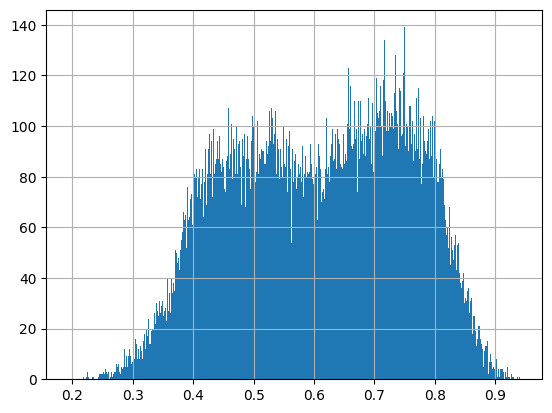

In [247]:
all_anns_df['total_dif'].hist(bins=1000)

Looking at the distribution, I can suggest three difficulty labels:
- Easy: images whose total_diff value is minor than 0.5
- Medium: images whose total_diff value is between 0.5 and 0.7
- Hard: images whose total_diff value is between 0.7 and 0.8
- Very Hard: images whose total_diff value is greater than 0.8

In [248]:
data = all_anns_df['total_dif'].sort_values()
easy = 0.5
medium = 0.7
hard = 0.8
easy_percent = float((data < easy).mean() * 100)
medium_percent = float(((data >= easy) & (data < medium)).mean() * 100)
hard_percent = float(((data >= medium) & (data < hard)).mean() * 100)
very_hard_percent = float((data >= hard).mean() * 100)

In [249]:
print(easy_percent)
print(medium_percent)
print(hard_percent)
print(very_hard_percent)

27.413684764702882
40.56688687736698
23.123821816143877
8.895606541786254


Here it's possible to see the percentiles the given value belong to. With this labeling we will have approximately the 27% of the data being considered as _easy_, 41% of the data considered as _medium_, 23% of the data considered as _hard_,  and 9% of the data being considered as _very hard_. 

In [252]:
def apply_total_dif_labeling(df, col):
    conditions = [
        (df[f'{col}'] < 0.4),
        (df[f'{col}'] > 0.85),
        (df[f'{col}'] > 0.6) & (df[f'{col}'] <= 0.85),
        (df[f'{col}'] >= 0.4) & (df[f'{col}'] <= 0.6)
    ]
    choices = ['easy', 'very hard', 'hard', 'medium']
    df['label'] = np.select(conditions, choices, default='unknown')
    return df

In [253]:
all_anns_df = apply_total_dif_labeling(all_anns_df, 'total_dif')

## Precision

In [254]:
def detect_on_threshold(df, threshold):
    df['detected'] = df['Confidence'].apply(lambda x: 1 if x>=threshold else 0)

In [255]:
detect_on_threshold(all_predictions_df, 0.5)

## Grouping

In [256]:
grouped_predictions_df = all_predictions_df.groupby('Img_ID').agg(
    {
        'Confidence': 'mean',
        'detected': 'sum',
    }
)

In [257]:
df_out = pd.merge(all_anns_df, grouped_predictions_df, how='inner', left_on='Img', right_on='Img_ID')
df_out.set_index('Img', inplace=True)
df_out = df_out[['Confidence', 'label', 'detected', 'num_people']]

In [ ]:
def adding_precision_feature(df):
    df['accuracy'] = df['detected']/df['num_people']

In [274]:
def adding_metrics_features(df):
    df['mae'] = np.abs(df['num_people']-df['detected'])
    df['mse'] = (df['num_people']-df['detected'])**2
    df['correct'] =(df['detected'] == df['num_people']).astype(int)

In [275]:
adding_precision_feature(df_out)
adding_metrics_features(df_out)

In [276]:
df_out

,Confidence,label,detected,num_people,accuracy,mae,mse,correct
Img,,,,,,,,
326,0.866764,medium,1,1,1.00,0,0,1
1149,0.607025,hard,9,12,0.75,3,9,0
1200,0.739418,hard,3,3,1.00,0,0,1
1319,0.431452,medium,0,1,0.00,1,1,0
1900,0.000000,hard,0,1,0.00,1,1,0
...,...,...,...,...,...,...,...,...
579891,0.909920,medium,1,1,1.00,0,0,1
580781,0.841013,medium,1,1,1.00,0,0,1
581183,0.605279,hard,3,12,0.25,9,81,0


### Plotting

In [287]:
def plot_grouped_boxplot(df, feature):
    plt.figure(figsize=(8, 6))
    custom_palette = {
        'easy': 'yellow',
        'medium': 'orange',
        'hard': 'red',
        'very hard': 'purple'
    }

    label_order = ['easy', 'medium', 'hard', 'very hard']


    sns.boxplot(data=df, x='label', y=feature, hue='label', palette=custom_palette, dodge=False, legend=False, order=label_order)
    plt.title(f"Boxplot of {feature} by Label")
    plt.xlabel("Label")
    plt.ylabel(f"{feature}")

    plt.show()

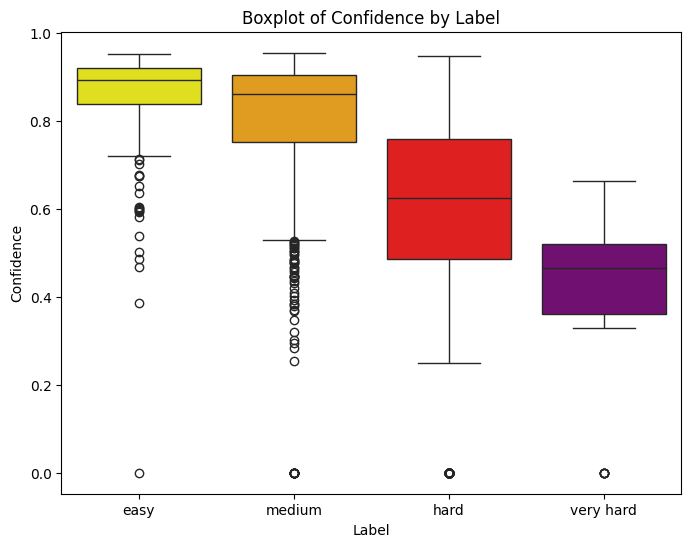

In [288]:
plot_grouped_boxplot(df_out, 'Confidence')

In [289]:
label_grouped = df_out.groupby('label').agg(
    {
        'mae': 'mean',
        'mse': 'mean',
        'correct': 'mean'
    }
)

label_grouped['rmse'] = np.sqrt(label_grouped['mse'])
label_grouped

,mae,mse,correct,rmse
label,,,,
easy,0.033113,0.033113,0.966887,0.181969
hard,2.103483,1.144898,0.279602,1.069999
medium,0.167079,0.151921,0.857673,0.389771
very hard,5.567568,2.265216,0.000000,1.505063


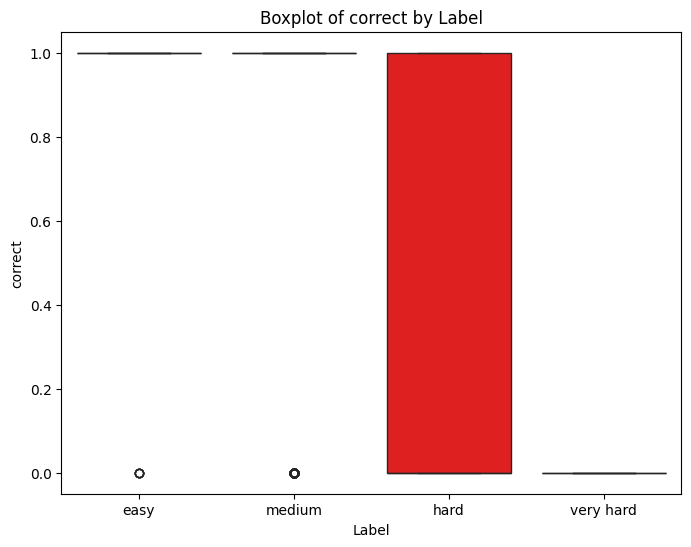

In [290]:
plot_grouped_boxplot(df_out, 'correct')